# Nearest neighbor analysis for neuron and glias



In [1]:
import os, sys,z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.io import imread, imsave
from os.path import abspath, dirname
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats, spatial
import seaborn as sns
from scipy import ndimage, misc

###### Load data files
1. marker gene spot counts
2. metadata with molecular cell type information 
3. neuron metadata (position, cell size and shape)

In [2]:
lha_neuron=pd.read_csv('directory/spotcount/neuron',sep=',', index_col=0)
ex_m=pd.read_csv('/Slc17a6/molecular/type/metadata',sep=',', index_col=0)
inh_m=pd.read_csv('/Slc32a1/molecular/type/metadata',sep=',', index_col=0)
lha_neuron=lha_neuron.T
lha_neuron=lha_neuron.where(lha_neuron>=0, 0)
roi=pd.read_csv('directory/roi/metadata',sep=',', index_col=0)

cluster=pd.concat([ex_m,inh_m],axis=0)

c=['Ex-1', 'Ex-2', 'Ex-3', 'Ex-4',
   'Ex-5', 'Ex-6', 'Ex-7', 'Ex-8', 
   'Ex-9', 'Ex-10', 'Ex-11', 'Ex-12', 
   'Ex-13', 'Ex-14', 'Ex-15', 'Ex-16', 
   'Ex-17', 'Ex-18', 'Ex-19', 'Ex-20',
   'Ex-21', 'Ex-22', 'Ex-23', 'Ex-24', 
   'Ex-25','Inh-1', 'Inh-2','Inh-3', 'Inh-4', 
   'Inh-5', 'Inh-6', 'Inh-7', 'Inh-8', 'Inh-9', 
   'Inh-10', 'Inh-11', 'Inh-12', 'Inh-13', 'Inh-14',
   'Inh-15', 'Inh-16', 'Inh-17', 'Inh-18', 'Inh-19',
   'Inh-20', 'Inh-21', 'Inh-22', 'Inh-23']

###### Neighborhood (50µm radius) complexity and purity analysis
similar to Moffitt, et al. Science, 2018



In [3]:
roi=roi[roi.index.isin(ex_m.index)|roi.index.isin(inh_m.index)]

In [5]:
for i in roi.index:
    roi.loc[i, 'cluster']=cluster.loc[i,'x']

In [29]:
a=roi.to_numpy()[:,:3]
radius   = 50   
neuron=spatial.KDTree(a)
neighbors=neuron.query_ball_point(a,radius)    

In [30]:
roi['neighbor_complexity']=-1
roi['major_cluster']=''
roi['fraction_major_cluster']=-1.000


In [31]:
for i in range(0,len(neighbors)):
    x=[]
    for j in neighbors[i]:
        x=np.append(x, roi.iat[j,16])
    a,b=np.unique(x,return_counts=True)
    roi.iat[i,17]=len(a)
    roi.iat[i,18]=a[b.argmax()]
    roi.iat[i,19]=(b.max()/len(x))

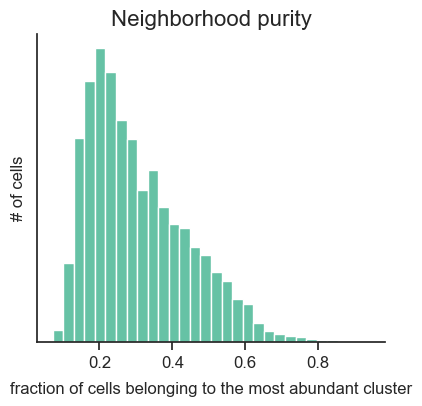

In [35]:
sns.set(style='ticks', palette='Set2')
fig = plt.figure(figsize=(4.5,4))
plt.hist(roi['fraction_major_cluster'],bins=30);
plt.title('Neighborhood purity', fontsize=16)
plt.xlabel('fraction of cells belonging to the most abundant cluster',fontsize=12)
plt.ylabel('# of cells',fontsize=12)
plt.yticks(ticks=[],fontsize=12);
plt.xticks(fontsize=12);
sns.despine()

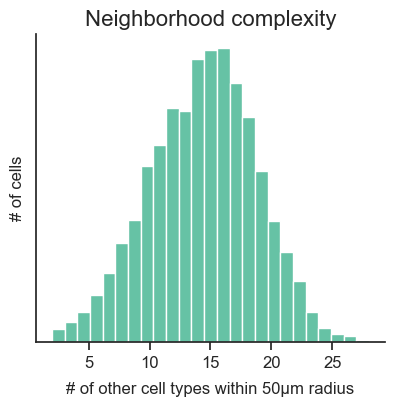

In [39]:
sns.set(style='ticks', palette='Set2')
fig = plt.figure(figsize=(4.5,4))
plt.hist(roi['neighbor_complexity'],bins=25);
plt.title('Neighborhood complexity', fontsize=16)
plt.xlabel('# of other cell types within 50µm radius',fontsize=12)
plt.ylabel('# of cells',fontsize=12)
plt.yticks(ticks=[],fontsize=12);
plt.xticks(fontsize=12);
sns.despine()

###### Print the most abundant cluster in the neighborhood

In [ ]:
neighbor_cluster=pd.DataFrame(np.empty([len(cluster),0]),index=cluster)
for nn in matrix.index:
    a,b=np.unique(roi[roi.cluster==nn].major_cluster.to_numpy(),return_counts=True)
    neighbor_cluster.loc[nn,'neighbor']=a[b.argmax()]
    neighbor_cluster.loc[nn,'fraction']=(b.max()/len(roi[roi.cluster==nn]))

In [ ]:
neighbor_cluster.reindex(c)

###### Compute the average distance to nearest neighbor (ANN) of each molecular cluster

In [40]:
# cluster=np.unique(roi.cluster.to_numpy())
matrix=pd.DataFrame(np.empty([len(c),len(c)]),index=c, columns=c)
for n in c:
    for m in c:
        if m==n:
            dist,r=spatial.KDTree(roi[roi.cluster==n].to_numpy()[:,:3]).query(roi[roi.cluster==m].to_numpy()[:,:3], k=2)
            matrix.loc[n,m]=np.mean(dist[dist!=0])
        else:
            dist,r=spatial.KDTree(roi[roi.cluster==n].to_numpy()[:,:3]).query(roi[roi.cluster==m].to_numpy()[:,:3], k=1)
            matrix.loc[n,m]=np.mean(dist[dist!=0])
            

In [19]:
matrix=matrix.reindex(c)

In [20]:
matrix=matrix[matrix.index]

In [73]:
matrix_new=matrix[matrix.index[ax.dendrogram_row.reordered_ind]]

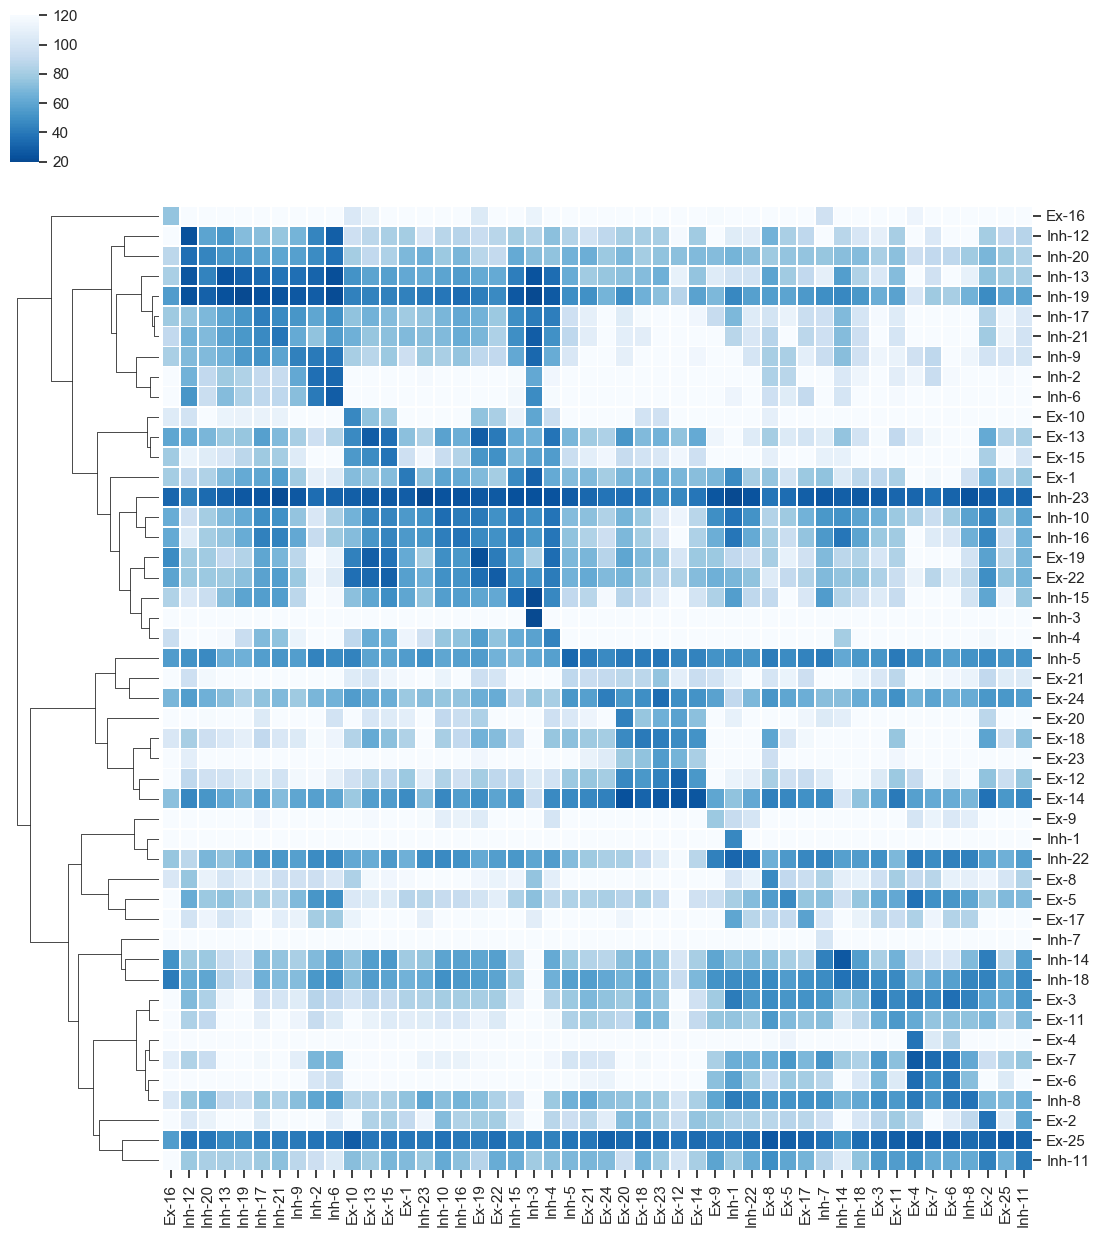

In [77]:
ax=sns.clustermap(matrix_new, metric="correlation",
                 cmap=blue,vmax=120,col_cluster=False,vmin=20,figsize = (13.2,15),linewidth=0.5)

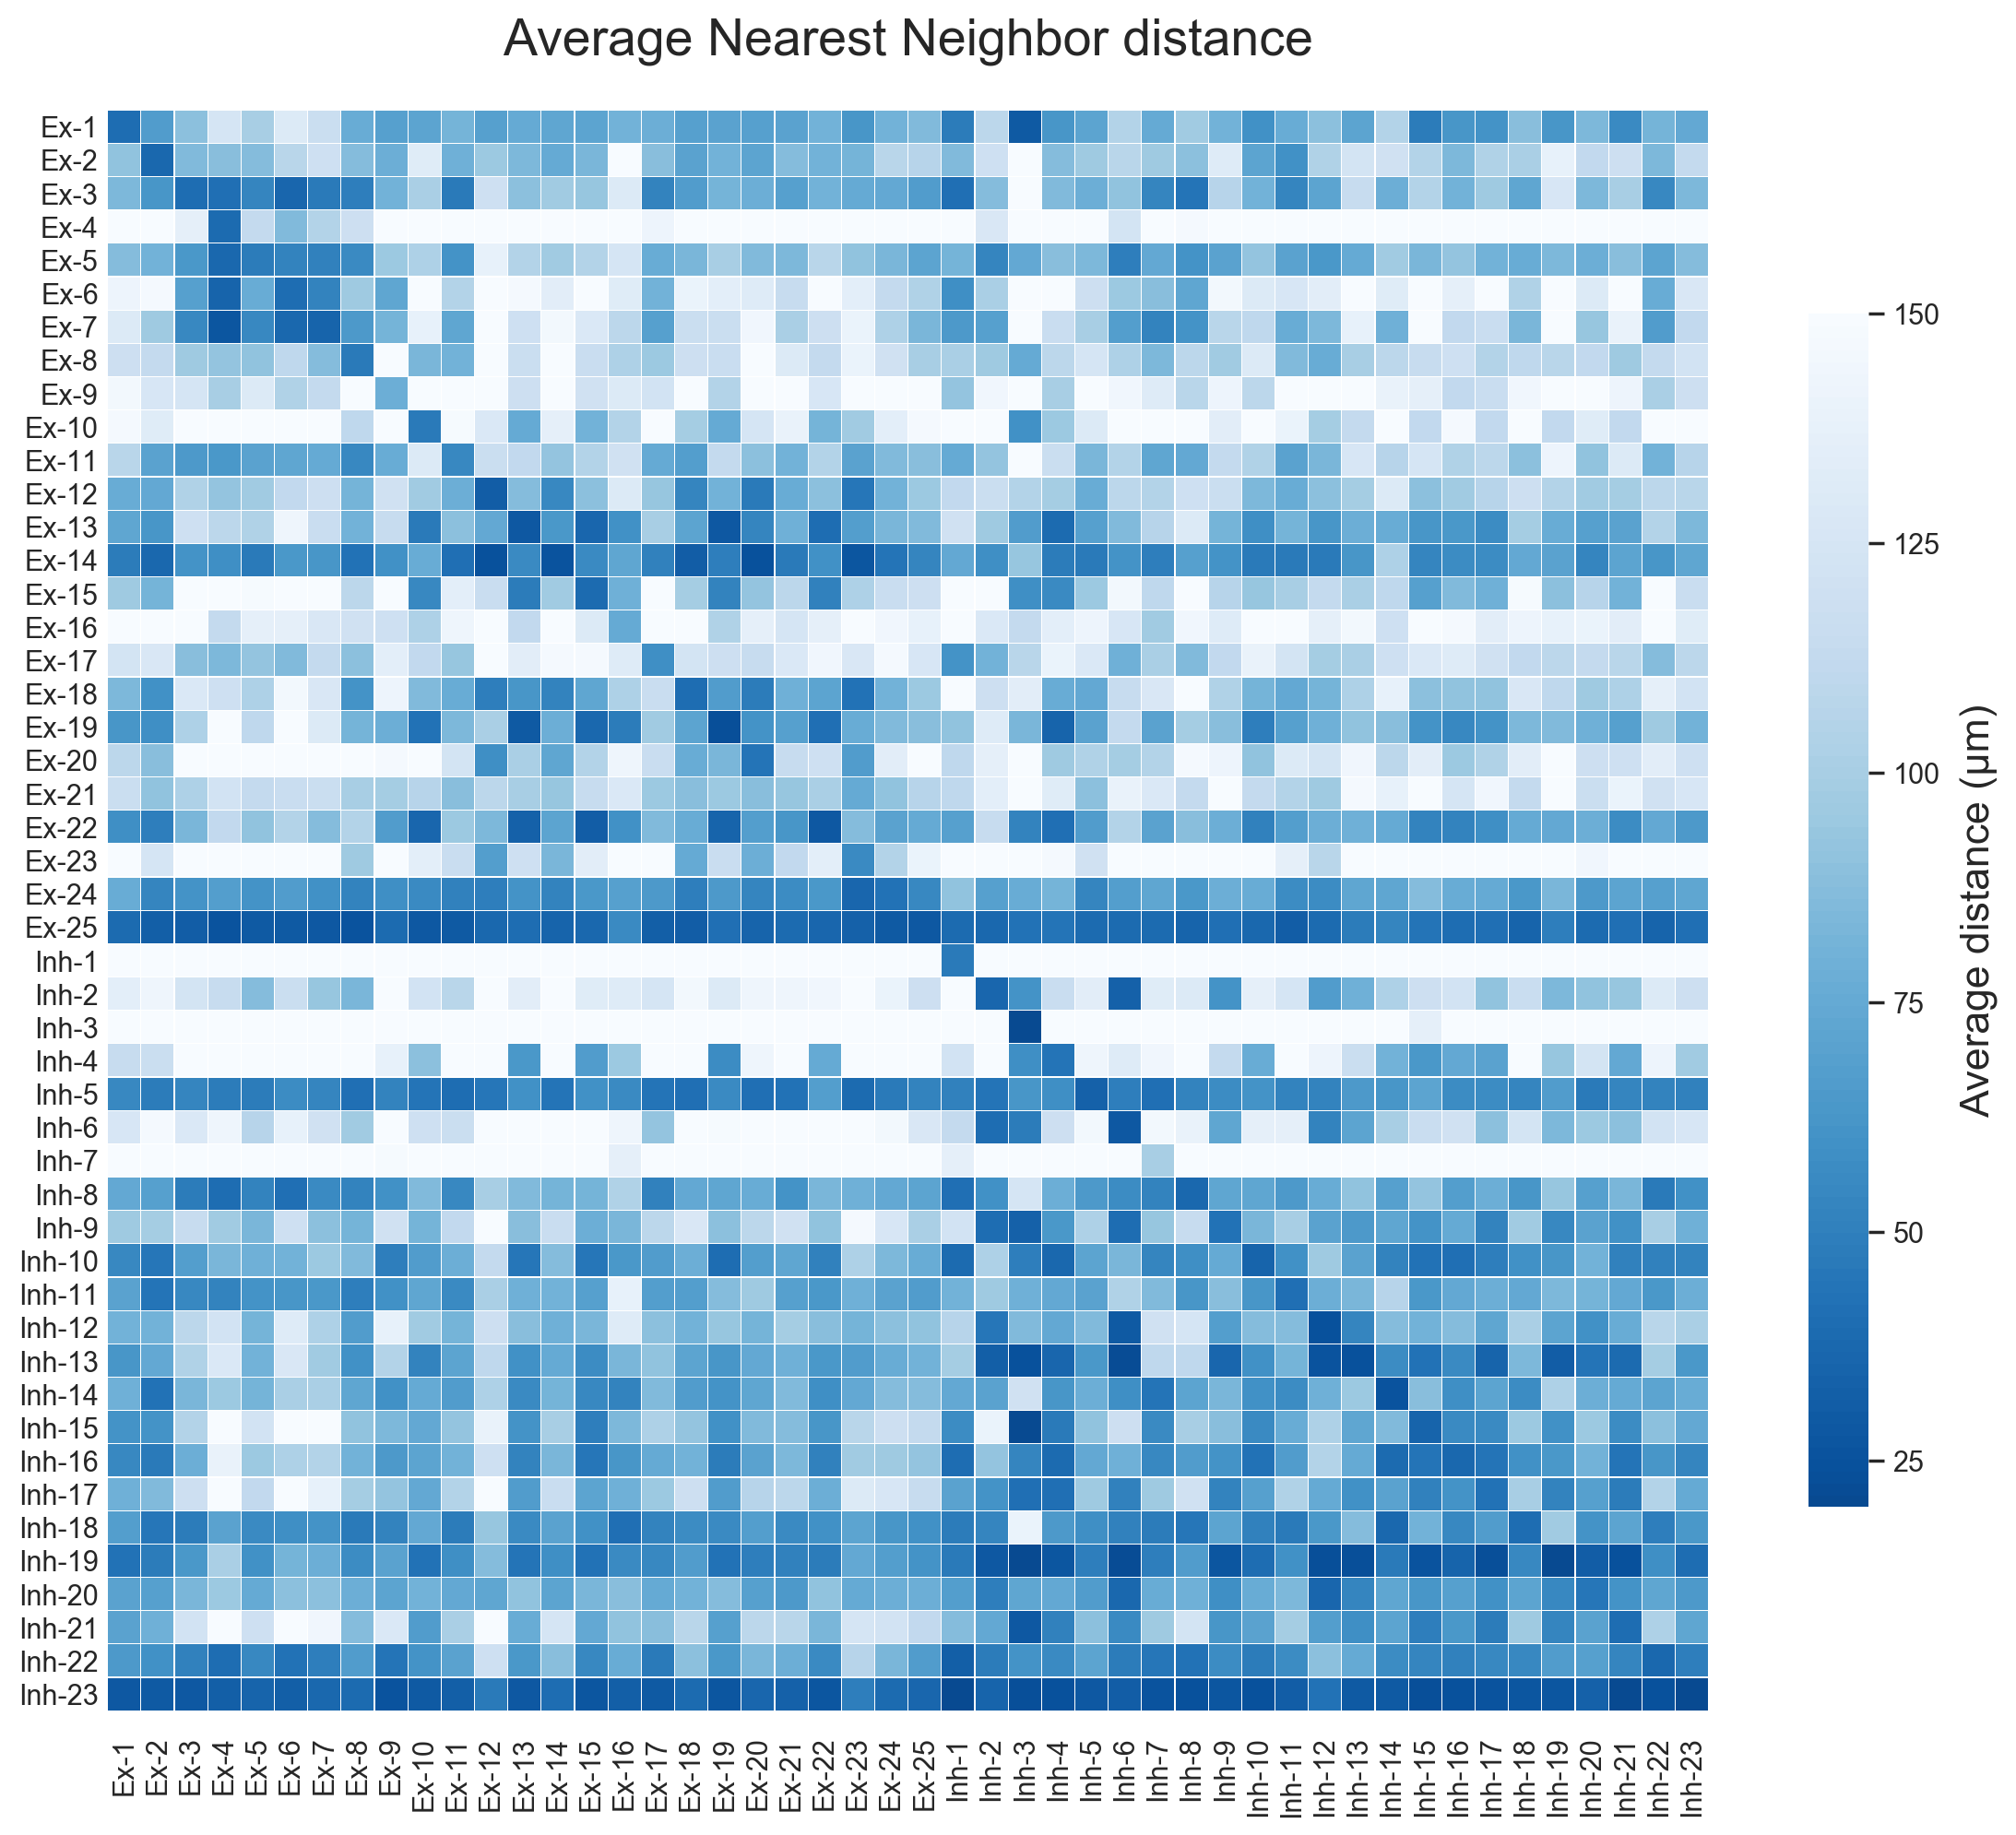

In [50]:
plt.figure(figsize = (14,12),dpi=200) 
ax = sns.heatmap(
    matrix,
    vmax=150,
    vmin=20,
    cmap=blue,
    square=True, cbar=True, linewidth=0.05,cbar_kws={"shrink": .7,'label': 'Average distance (µm)'},
);
ax.figure.axes[-1].yaxis.label.set_size(16)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Average Nearest Neighbor distance', fontsize=20, pad=15)
ax.tick_params(size=0)